In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from sklearn.metrics import accuracy_score
from kaggle.competitions import twosigmanews
import gc
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
import random
random.seed(1)
import time

import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import get_scorer
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone
from functools import partial
from hyperopt import hp, fmin, tpe
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from multiprocessing import Pool
from itertools import chain
import pickle

In [2]:
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()
gc.enable()

Loading the data... This could take a minute.
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()##load data
market_train_df['date'] = market_train_df['time'].dt.strftime('%Y-%m-%d')

In [4]:
column_market = ['returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
column_raw = ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1','returnsClosePrevRaw10', 'returnsOpenPrevRaw10']
for i in range(len(column_raw)):
    market_train_df[column_market[i]] = market_train_df[column_market[i]].fillna(market_train_df[column_raw[i]])

In [5]:
def fixBadReturnData(assetCode, badDate, badIndex, badReturnDataRanges, dayWindow):
    # store copy of bad data window
    badDataWindow = sampleAssetData(assetCode,badDate,dayWindow)
    badDataWindow.reset_index(inplace=True)
    # store indices needed to update raw and mktres return data
    newIdx = badDataWindow[badDataWindow['index'] == badIndex].index[0]
    indices = [
        # range of bad data for... returnsClosePrevRaw1 & returnsOpenPrevRaw1
        [badIndex,badDataWindow.loc[newIdx+badReturnDataRanges[0],'index']],
        # returnsClosePrevRaw10 & returnsOpenPrevRaw10
        [badIndex,badDataWindow.loc[newIdx+badReturnDataRanges[1],'index']],
        # returnsClosePrevMktres1 & returnsOpenPrevMktres1
        [badIndex,badDataWindow.loc[newIdx+badReturnDataRanges[2],'index']],
        # returnsClosePrevMktres10 & returnsOpenPrevMktres10
        [badIndex,badDataWindow.loc[newIdx+badReturnDataRanges[3],'index']],
        # returnsOpenNextMktres10
        [badDataWindow.loc[newIdx+badReturnDataRanges[4],'index'],badDataWindow.loc[newIdx+badReturnDataRanges[5],'index']]
    ]
    badDataWindow.set_index('index',inplace=True)
    # correct bad raw return data
    updateRawReturns(badDataWindow,indices)
    # estimate affected mktres return data
    updateMktresReturns(assetCode,badDataWindow,indices)

def updateMktresReturns(assetCode, assetData, indices):
    # update range of values for returnsClosePrevMktres1 & returnsOpenPrevMktres1
    sample1 = assetData[(assetData.index < indices[2][0]) | (assetData.index > indices[2][1])]
    rowsToUpdate1 = assetData[(assetData.index >= indices[2][0]) & (assetData.index <= indices[2][1])]
    for index, row in rowsToUpdate1.iterrows():
        market_train_df.loc[[index],['returnsClosePrevMktres1']] = estimateMktresReturn(sample1,'returnsClosePrevMktres1',index)
        market_train_df.loc[[index],['returnsOpenPrevMktres1']] = estimateMktresReturn(sample1,'returnsOpenPrevMktres1',index)
    # update range of values for returnsClosePrevMktres10 & returnsOpenPrevMktres10
    sample2 = assetData[(assetData.index < indices[3][0]) | (assetData.index > indices[3][1])]
    rowsToUpdate2 = assetData[(assetData.index >= indices[3][0]) & (assetData.index <= indices[3][1])]
    l = []
    for index, row in rowsToUpdate2.iterrows():
        market_train_df.loc[[index],['returnsClosePrevMktres10']] = estimateMktresReturn(sample2,'returnsClosePrevMktres10',index)
        est = estimateMktresReturn(sample2,'returnsOpenPrevMktres10',index)
        l.append(est)
        market_train_df.loc[[index],['returnsOpenPrevMktres10']] = est
    # update range of values for returnsOpenNextMktres10
    rowsToUpdate3 = assetData[(assetData.index >= indices[4][0]) & (assetData.index <= indices[4][1])]
    i = 0
    for index, row in rowsToUpdate3.iterrows():
        market_train_df.loc[[index],['returnsOpenNextMktres10']] = l[i]
        i += 1

def estimateMktresReturn(sampleData, mktresCol, index):
    sampleData['ones'] = 1
    rawCol = mktresCol.replace('Mktres','Raw')
    A = sampleData[[rawCol,'ones']]
    y = sampleData[mktresCol]
    m, c = np.linalg.lstsq(A,y,rcond=-1)[0]
    return c + m * market_train_df.loc[index,rawCol]

def updateRawReturns(assetData, indices):
    rowsToUpdate1 = assetData[(assetData.index >= indices[0][0]) & (assetData.index <= indices[0][1])]
    for index, row in rowsToUpdate1.iterrows():
        market_train_df.loc[[index],['returnsClosePrevRaw1']] = assetData['close'].pct_change()
        market_train_df.loc[[index],['returnsOpenPrevRaw1']] = assetData['open'].pct_change()
    rowsToUpdate2 = assetData[(assetData.index >= indices[1][0]) & (assetData.index <= indices[1][1])]
    for index, row in rowsToUpdate2.iterrows():
        market_train_df.loc[[index],['returnsClosePrevRaw10']] = assetData['close'].pct_change(periods=10)
        market_train_df.loc[[index],['returnsOpenPrevRaw10']] = assetData['open'].pct_change(periods=10)
        
def sampleAssetData(assetCode, date, numDays):
    d = datetime.strptime(date,'%Y-%m-%d')
    start = d - timedelta(days=numDays)
    end = d + timedelta(days=numDays)
    return market_train_df[(market_train_df['assetCode'] == assetCode)
                             & (market_train_df['time'] >= start.strftime('%Y-%m-%d'))
                             & (market_train_df['time'] <= end.strftime('%Y-%m-%d'))].copy()

In [6]:
# bad volume, open, and close for ZNGA.O on 2016-07-06

assetCode = 'ZNGA.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 19213100
market_train_df.loc[[badIndex],['open']] = 2.64
market_train_df.loc[[badIndex],['close']] = 2.75

badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges, sampleWindow)

# bad volume, open, and close for FLEX.O on 2016-07-06
assetCode = 'FLEX.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 5406600
market_train_df.loc[[badIndex],['open']] = 11.580
market_train_df.loc[[badIndex],['close']] = 11.750
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges, sampleWindow)

assetCode = 'SHLD.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 279300
market_train_df.loc[[badIndex],['open']] = 12.8900
market_train_df.loc[[badIndex],['close']] = 13.1400
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges, sampleWindow)

# bad volume, open, and close for MAT.O on 2016-07-06
assetCode = 'MAT.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 3242100
market_train_df.loc[[badIndex],['open']] = 32.13
market_train_df.loc[[badIndex],['close']] = 31.52
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges, sampleWindow)


assetCode = 'BBBY.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 4205500
market_train_df.loc[[badIndex],['open']] = 42.23
market_train_df.loc[[badIndex],['close']] = 43.55
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges,sampleWindow)


assetCode = 'DISH.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 2303300
market_train_df.loc[[badIndex],['open']] = 50.06
market_train_df.loc[[badIndex],['close']] = 51.33
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges,sampleWindow)


assetCode = 'NDAQ.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 733400
market_train_df.loc[[badIndex],['open']] = 64.64
market_train_df.loc[[badIndex],['close']] = 64.74
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges,sampleWindow)

assetCode = 'PCAR.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 2394300
market_train_df.loc[[badIndex],['open']] = 50.16
market_train_df.loc[[badIndex],['close']] = 50.79
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges,sampleWindow)

assetCode = 'PZZA.O'
badDate = '2016-07-06'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['volume']] = 185100
market_train_df.loc[[badIndex],['open']] = 67.86
market_train_df.loc[[badIndex],['close']] = 67.91
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges,sampleWindow)
gc.collect()

market_train_df.loc[market_train_df['assetCode'] == 'WW.N','assetCode'] = 'TW.N'
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'TW.N')
                                  & (market_train_df['time'] >= '2009-12-16')
                                  & (market_train_df['time'] < '2010-01-08'))]

market_train_df = market_train_df[~(market_train_df['open']==3288.1136)]

market_train_df = market_train_df[market_train_df['time'].dt.year >= 2009]

assetCode = 'PGN.N'
badDate = '2012-02-15'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# ranges of affected return data
badReturnDataRanges = [0,9,20,29,-11,18]
# sample data window (on either side of "badDate")
sampleWindow = 60
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges, sampleWindow)


qorvoDataToDrop = market_train_df[(market_train_df['assetCode'] == 'QRVO.O') 
                                         & (market_train_df['time'] < '2015-02-17')]
qorvoIndicesToDrop = list(qorvoDataToDrop.index)
market_train_df.drop(qorvoIndicesToDrop,inplace=True)

assetCode = 'TECD.O'
badDate = '2015-03-16'
badIndex = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate)].index[0]
# correct bad data
market_train_df.loc[[badIndex],['open']] = 56.18
# ranges of affected return data
badReturnDataRanges = [1,10,20,20,-11,9]
# sample data window (on either side of "badDate")
sampleWindow = 45
# fix bad return data in market_train_df
fixBadReturnData(assetCode,badDate,badIndex,badReturnDataRanges, sampleWindow)

market_train_df = market_train_df[~((market_train_df['assetCode'] == 'EBR.N')
                                  & (market_train_df['time'] >= '2016-10-01'))]


assetCode = 'HGSI.O'
badDate1 = '2009-08-03'
badIndex1 = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate1)].index[0]
dayWindow1 = 120
badReturnDataRanges1 = [-7,11,-14,19,-25,8]
badDataWindow1 = sampleAssetData(assetCode,badDate1,dayWindow1)
badDataWindow1.reset_index(inplace=True)
newIdx1 = badDataWindow1[badDataWindow1['index'] == badIndex1].index[0]
indices1 = [[],[],
    [badDataWindow1.loc[newIdx1+badReturnDataRanges1[0],'index'],badDataWindow1.loc[newIdx1+badReturnDataRanges1[1],'index']],
    [badDataWindow1.loc[newIdx1+badReturnDataRanges1[2],'index'],badDataWindow1.loc[newIdx1+badReturnDataRanges1[3],'index']],
    [badDataWindow1.loc[newIdx1+badReturnDataRanges1[4],'index'],badDataWindow1.loc[newIdx1+badReturnDataRanges1[5],'index']]
]
badDataWindow1.set_index('index',inplace=True)
updateMktresReturns(assetCode,badDataWindow1,indices1)
# dropping HGSI.O data in Feb and Mar 2016
hgsiDataToDrop = market_train_df[(market_train_df['assetCode'] == 'HGSI.O')
                                  & (market_train_df['time'] < '2009-04-01')]
hgsiIndicesToDrop = list(hgsiDataToDrop.index)
market_train_df.drop(hgsiIndicesToDrop,inplace=True)
gc.collect()

28

In [7]:
print('Removing strange data ...')
orig_len = market_train_df.shape[0]
market_train_df = market_train_df[~market_train_df['assetCode'].isin(['PGN.N','EBRYY.OB'])]
#market_train_df = market_train_df[~market_train_df['assetName'].isin(['Unknown'])]
new_len = market_train_df.shape[0]
rmv_len = np.abs(orig_len-new_len)
print('There were %i lines removed' %rmv_len)
market_train_df=market_train_df[market_train_df['time'] > '2011-01-01']

market_train_df['time'] = market_train_df['time'].dt.date
def create_lag(df_code,n_lag=[3,7,10,14],shift_size=1):
    code = df_code['assetCode'].unique()
    
    for col in return_features:
        for window in n_lag:
            rolled = df_code[col].shift(shift_size).rolling(window=window)
            lag_mean = rolled.mean()
            lag_max = rolled.max()
            lag_min = rolled.min()
            lag_std = rolled.std()
            df_code['%s_lag_%s_mean'%(col,window)] = lag_mean
            df_code['%s_lag_%s_max'%(col,window)] = lag_max
            df_code['%s_lag_%s_min'%(col,window)] = lag_min
#             df_code['%s_lag_%s_std'%(col,window)] = lag_std
    return df_code.fillna(-1)

def generate_lag_features(df,n_lag = [3,7,10,14]):
    features = ['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe']
    
    assetCodes = df['assetCode'].unique()
    print(assetCodes)
    all_df = []
    df_codes = df.groupby('assetCode')
    df_codes = [df_code[1][['time','assetCode']+return_features] for df_code in df_codes]
    print('total %s df'%len(df_codes))
    
    pool = Pool(4)
    all_df = pool.map(create_lag, df_codes)
    
    new_df = pd.concat(all_df)  
    new_df.drop(return_features,axis=1,inplace=True)
    pool.close()
    
    return new_df

return_features = ['returnsClosePrevMktres10','returnsClosePrevRaw10','open','close']
n_lag = [3,7,10,14]
new_df = generate_lag_features(market_train_df,n_lag=n_lag)
market_train_df = pd.merge(market_train_df,new_df,how='left',on=['time','assetCode'])
gc.collect()

Removing strange data ...
There were 586 lines removed
['A.N' 'AAI.N' 'AAP.N' ... 'FCB.N' 'AMC.N' 'CVGW.O']
total 3159 df


21

In [8]:
def mis_impute(data):
    for i in data.columns:
        if data[i].dtype == "object":
            data[i] = data[i].fillna("other")
        elif (data[i].dtype == "int64" or data[i].dtype == "float64"):
            data[i] = data[i].fillna(data[i].mean())
        else:
            pass
    return data

market_train_df = mis_impute(market_train_df)

def data_prep(market_train):
    lbl = {k: v for v, k in enumerate(market_train['assetCode'].unique())}
    market_train['assetCodeT'] = market_train['assetCode'].map(lbl)
    market_train = market_train.dropna(axis=0)
    return market_train

market_train_df = data_prep(market_train_df)
gc.collect()
del new_df 

news_train_df['assetCodes'] = news_train_df['assetCodes'].str.findall(f"'([\w\./]+)'")    
# Expand assetCodes
assetCodes_expanded = list(chain(*news_train_df['assetCodes']))
assetCodes_index = news_train_df.index.repeat( news_train_df['assetCodes'].apply(len) )

df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode1': assetCodes_expanded})
del assetCodes_expanded, assetCodes_index

assetCode_in_market = list(market_train_df['assetCode'])
unique_assetCode = pd.DataFrame({'assetCodes':assetCode_in_market}).drop_duplicates()
del assetCode_in_market 

assetCode_in_use = pd.merge(df_assetCodes, unique_assetCode, left_on='assetCode1', right_on='assetCodes', how='left')
assetCode_in_use= assetCode_in_use.dropna(axis=0)
assetCode_in_use = assetCode_in_use.drop('assetCodes', axis=1)
del unique_assetCode
gc.collect()
news_train_df_expanded = pd.merge(assetCode_in_use, news_train_df, left_on='level_0', right_index=True, suffixes=(['','_old']))

# market_train_df['time'] = market_train_df.time.dt.date
news_train_df_expanded['time'] = news_train_df_expanded.time.dt.hour
news_train_df_expanded['firstCreated'] = news_train_df_expanded.firstCreated.dt.date

kcol = ['firstCreated', 'assetCode1']
news_train_df2 = news_train_df_expanded.groupby(kcol, as_index=False).mean()
del news_train_df, news_train_df_expanded
gc.collect()

training = pd.merge(market_train_df, news_train_df2, how='left', left_on=['time', 'assetCode'], 
                            right_on=['firstCreated', 'assetCode1'])
training['time']=training['time_x']
training = training.drop(columns = ['firstCreated','assetCode1','assetName','level_0','time_x','time_y','takeSequence']).fillna(0) 
del market_train_df, news_train_df2
gc.collect()

42

In [9]:
grouped=training.groupby('assetCode')
training['closeopentovolume']=(training['close']+training['open'])*training['volume']

    #---------------------------quant features---------------------------------------------------
new_column = grouped.apply(lambda x: x['close'].ewm(span=30).mean())
training["close_30EMA"] = new_column.reset_index(level=0, drop=True)
new_column = grouped.apply(lambda x: x['close'].ewm(span=26).mean())
training["close_26EMA"] = new_column.reset_index(level=0, drop=True)
new_column = grouped.apply(lambda x: x['close'].ewm(span=12).mean())
training["close_12EMA"] = new_column.reset_index(level=0, drop=True)
training['MACD'] = training['close_12EMA'] - training['close_26EMA']
no_of_std = 2
    #--------------------------bolinger band---------------------------------------
new_column=grouped['close'].rolling(window=7).mean()
training['MA_7MA'] =  new_column.reset_index(level=0, drop=True)
new_column=grouped['close'].rolling(window=7).std()
training['MA_7MA_std'] =  new_column.reset_index(level=0, drop=True)
training['MA_7MA_BB_high'] = training['MA_7MA'] + no_of_std * training['MA_7MA_std']
training['MA_7MA_BB_low'] = training['MA_7MA'] - no_of_std * training['MA_7MA_std']
training = training.dropna(axis=0)
del grouped
gc.collect()

55

In [ ]:
corr = training.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(80,80)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True, fmt="0.2g",linecolor='white', cmap=plt.cm.RdBu)

In [10]:
num_cols=['volume','close','open','returnsClosePrevRaw1','returnsOpenPrevRaw1','returnsClosePrevMktres1',
'returnsOpenPrevMktres1','returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10',
'returnsOpenPrevMktres10','returnsClosePrevMktres10_lag_3_mean','returnsClosePrevMktres10_lag_3_max','returnsClosePrevMktres10_lag_3_min',
'returnsClosePrevMktres10_lag_7_mean','returnsClosePrevMktres10_lag_7_max','returnsClosePrevMktres10_lag_7_min',
'returnsClosePrevMktres10_lag_10_mean','returnsClosePrevMktres10_lag_10_max','returnsClosePrevMktres10_lag_10_min',
'returnsClosePrevMktres10_lag_14_mean','returnsClosePrevMktres10_lag_14_max','returnsClosePrevMktres10_lag_14_min',
'returnsClosePrevRaw10_lag_3_mean','returnsClosePrevRaw10_lag_3_max','returnsClosePrevRaw10_lag_3_min',
'returnsClosePrevRaw10_lag_7_mean','returnsClosePrevRaw10_lag_7_max','returnsClosePrevRaw10_lag_7_min',
'returnsClosePrevRaw10_lag_10_mean','returnsClosePrevRaw10_lag_10_max','returnsClosePrevRaw10_lag_10_min',
'returnsClosePrevRaw10_lag_14_mean','returnsClosePrevRaw10_lag_14_max','returnsClosePrevRaw10_lag_14_min',
'volumeCounts5D','volumeCounts7D','closeopentovolume','sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
'close_30EMA','close_26EMA','close_12EMA','MACD','MA_7MA','MA_7MA_std','MA_7MA_BB_high','MA_7MA_BB_low']


In [11]:
use_cols=['returnsClosePrevRaw1','returnsOpenPrevRaw1','returnsClosePrevMktres1',
'returnsOpenPrevMktres1','returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10',
'returnsOpenPrevMktres10','returnsClosePrevMktres10_lag_3_mean',
'returnsClosePrevMktres10_lag_7_mean',
'returnsClosePrevMktres10_lag_10_mean',
'returnsClosePrevMktres10_lag_14_mean',
'returnsClosePrevRaw10_lag_3_mean',
'returnsClosePrevRaw10_lag_7_mean',
'returnsClosePrevRaw10_lag_10_mean',
'returnsClosePrevRaw10_lag_14_mean','sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
'volumeCounts5D','volumeCounts7D','closeopentovolume','sentimentClass',
'close_30EMA','close_26EMA','close_12EMA','MACD','MA_7MA','MA_7MA_std','MA_7MA_BB_high','MA_7MA_BB_low']
cat_columns = ['assetCodeT']
feature_columns = use_cols+cat_columns

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
print('scaling numerical columns')
data_scaler = StandardScaler()
#market_train_df[num_columns] = data_scaler.fit_transform(market_train_df[num_columns])
#data_scaler = MinMaxScaler()
training[num_cols] = data_scaler.fit_transform(training[num_cols])
gc.collect()

scaling numerical columns


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0

In [15]:
from sklearn.model_selection import train_test_split

training = training.reset_index()
#training = training.drop(columns='index')

# Random train-test split
train_indices, val_indices = train_test_split(training.index.values,test_size=0.1, random_state=92)

In [16]:
def get_input(market_train, indices):
    X = market_train.loc[indices, feature_columns].values
    y = market_train.loc[indices,'returnsOpenNextMktres10'].map(lambda x: 0 if x<0 else 1).values
    r = market_train.loc[indices,'returnsOpenNextMktres10'].values
    u = market_train.loc[indices, 'universe']
    d = market_train.loc[indices, 'date']
    return X,y,r,u,d

# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(training, train_indices)
X_val,y_val,r_val,u_val,d_val = get_input(training, val_indices)

In [17]:
def learning_rate_power(current_round):
    base_learning_rate = 0.19
    min_learning_rate = 0.01
    lr = base_learning_rate * np.power(0.995,current_round)
    return max(lr, min_learning_rate)

In [18]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

tune_params = {'n_estimators': [200,500,1000,2500,5000],
              'max_depth': sp_randint(4,12),
              'colsample_bytree':sp_uniform(loc=0.8, scale=0.15),
              'min_child_samples':sp_randint(60,120),
              'subsample': sp_uniform(loc=0.75, scale=0.25),
              'reg_lambda':[1e-3, 1e-2, 1e-1, 1]}

fit_params = {'early_stopping_rounds':200,
              'eval_metric': 'accuracy',
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose': 100,
              'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_power)]}

In [19]:
gc.collect()

194

In [20]:
lgb_clf = lgb.LGBMClassifier(n_jobs=4, objective='binary',random_state=1)
gs = RandomizedSearchCV(estimator=lgb_clf, 
                        param_distributions=tune_params, 
                        n_iter=30,
                        scoring='f1',
                        cv=5,
                        refit=True,
                        random_state=1,
                        verbose=True)
#gs.fit(X_train, y_train)
#print('best params：',gs.best_params_) 

In [21]:
lgb_clf = lgb.LGBMClassifier(n_jobs=4,
                             objective='binary',
                            random_state=1)
opt_params = {'colsample_bytree': 0.9126218154704233,
              'max_depth': 9,
              'boosting_type': 'gbdt',
              'min_child_samples': 70, 
              'n_estimators': 5000, 
              'reg_lambda': 0.01, 
              'subsample': 0.9119373499433369}


lgb_clf.set_params(**opt_params)
lgb_clf.fit(X_train, y_train,**fit_params)

Training until validation scores don't improve for 40 rounds.
[20]	training's binary_logloss: 0.681143	valid_1's binary_logloss: 0.681895
[40]	training's binary_logloss: 0.679846	valid_1's binary_logloss: 0.68096
[60]	training's binary_logloss: 0.679002	valid_1's binary_logloss: 0.680428
[80]	training's binary_logloss: 0.678338	valid_1's binary_logloss: 0.680064
[100]	training's binary_logloss: 0.677773	valid_1's binary_logloss: 0.679732
[120]	training's binary_logloss: 0.677334	valid_1's binary_logloss: 0.679551
[140]	training's binary_logloss: 0.67685	valid_1's binary_logloss: 0.679281
[160]	training's binary_logloss: 0.676459	valid_1's binary_logloss: 0.679086
[180]	training's binary_logloss: 0.676125	valid_1's binary_logloss: 0.678914
[200]	training's binary_logloss: 0.675838	valid_1's binary_logloss: 0.678802
[220]	training's binary_logloss: 0.675564	valid_1's binary_logloss: 0.678665
[240]	training's binary_logloss: 0.67534	valid_1's binary_logloss: 0.678561
[260]	training's bina

[2140]	training's binary_logloss: 0.670807	valid_1's binary_logloss: 0.676391
[2160]	training's binary_logloss: 0.670774	valid_1's binary_logloss: 0.676377
[2180]	training's binary_logloss: 0.67074	valid_1's binary_logloss: 0.676362
[2200]	training's binary_logloss: 0.670706	valid_1's binary_logloss: 0.676346
[2220]	training's binary_logloss: 0.670674	valid_1's binary_logloss: 0.676333
[2240]	training's binary_logloss: 0.670641	valid_1's binary_logloss: 0.676316
[2260]	training's binary_logloss: 0.670606	valid_1's binary_logloss: 0.6763
[2280]	training's binary_logloss: 0.670575	valid_1's binary_logloss: 0.676286
[2300]	training's binary_logloss: 0.670541	valid_1's binary_logloss: 0.676272
[2320]	training's binary_logloss: 0.670509	valid_1's binary_logloss: 0.676256
[2340]	training's binary_logloss: 0.670477	valid_1's binary_logloss: 0.67624
[2360]	training's binary_logloss: 0.670442	valid_1's binary_logloss: 0.676225
[2380]	training's binary_logloss: 0.670408	valid_1's binary_logloss:

[4260]	training's binary_logloss: 0.667369	valid_1's binary_logloss: 0.674885
[4280]	training's binary_logloss: 0.66734	valid_1's binary_logloss: 0.674873
[4300]	training's binary_logloss: 0.667309	valid_1's binary_logloss: 0.674859
[4320]	training's binary_logloss: 0.667278	valid_1's binary_logloss: 0.674845
[4340]	training's binary_logloss: 0.667243	valid_1's binary_logloss: 0.674826
[4360]	training's binary_logloss: 0.667212	valid_1's binary_logloss: 0.674814
[4380]	training's binary_logloss: 0.667185	valid_1's binary_logloss: 0.674805
[4400]	training's binary_logloss: 0.667152	valid_1's binary_logloss: 0.674792
[4420]	training's binary_logloss: 0.667123	valid_1's binary_logloss: 0.67478
[4440]	training's binary_logloss: 0.667091	valid_1's binary_logloss: 0.674769
[4460]	training's binary_logloss: 0.667059	valid_1's binary_logloss: 0.674754
[4480]	training's binary_logloss: 0.667026	valid_1's binary_logloss: 0.674741
[4500]	training's binary_logloss: 0.66699	valid_1's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9126218154704233, importance_type='split',
        learning_rate=0.1, max_depth=9, min_child_samples=70,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=4, num_leaves=31, objective='binary', random_state=1,
        reg_alpha=0.0, reg_lambda=0.01, silent=True,
        subsample=0.9119373499433369, subsample_for_bin=200000,
        subsample_freq=0)

In [22]:
# before voting ensemble
print('Training accuracy: ', accuracy_score(y_train, lgb_clf.predict(X_train)))
print('Validation accuracy: ', accuracy_score(y_val, lgb_clf.predict(X_val)))

Training accuracy:  0.5944005513400358
Validation accuracy:  0.5775359318625422


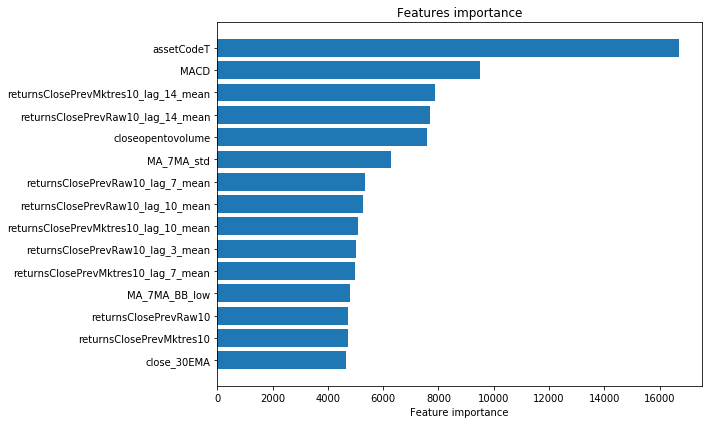

In [23]:
features_imp = pd.DataFrame()
features_imp['features'] = list(feature_columns)[:]
features_imp['importance'] = lgb_clf.feature_importances_
features_imp = features_imp.sort_values(by='importance', ascending=False).reset_index()

y_plot = -np.arange(15)
plt.figure(figsize=(10,6))
plt.barh(y_plot, features_imp.loc[:14,'importance'].values)
plt.yticks(y_plot,(features_imp.loc[:14,'features']))
plt.xlabel('Feature importance')
plt.title('Features importance')
plt.tight_layout()

In [24]:
def rescale(data_in, data_ref):
    scaler_ref =  StandardScaler()
    scaler_ref.fit(data_ref.reshape(-1,1))
    scaler_in = StandardScaler()
    data_in = scaler_in.fit_transform(data_in.reshape(-1,1))
    data_in = scaler_ref.inverse_transform(data_in)[:,0]
    return data_in

In [25]:
def confidence_out(y_pred):
    confidence = np.zeros(y_pred.shape[0])
    for i in range(len(confidence)):
        if y_pred[i,:].argmax() != 1:
            confidence[i] = y_pred[i,2]-y_pred[i,0]
    return confidence

In [26]:
y_pred_proba = lgb_clf.predict_proba(X_val)
predicted_return = y_pred_proba[:,1] - y_pred_proba[:,0]
#predicted_return = confidence_out(y_pred_proba)
predicted_return = rescale(predicted_return, r_train)

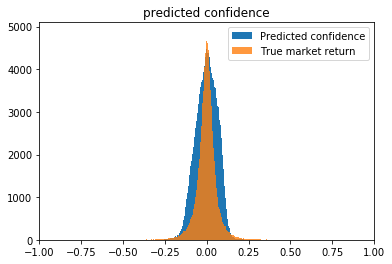

In [27]:
# distribution of confidence that will be used as submission
plt.hist(predicted_return, bins='auto', label='Predicted confidence')
plt.hist(r_val, bins='auto',alpha=0.8, label='True market return')
plt.title("predicted confidence")
plt.legend(loc='best')
plt.xlim(-1,1)
plt.show()

In [44]:
r_val = r_val.clip(-1,1) # get rid of outliers.
x_t_i = predicted_return * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print('Before voting ensemble, Validation score', score_valid)

Before voting ensemble, Validation score 0.7463947564055972


In [31]:
clfs = []
for i in range(20):
    clf = lgb.LGBMClassifier(learning_rate=0.1, random_state=1200+i, silent=True,
                             n_jobs=4, n_estimators=5000)
    clf.set_params(**opt_params)
    clfs.append(('lgbm%i'%i, clf))

def split_data(X, y, test_percentage=0.2, seed=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage)
    return X_train, y_train, X_test, y_test 

def _parallel_fit_estimator(estimator, X, y, sample_weight=None, **fit_params):
    
    # randomly split the data so we have a test set for early stopping
    X_train, y_train, X_test, y_test = split_data(X, y, seed=1994)
    
    # update the fit params with our new split
    fit_params["eval_set"] = [(X_train,y_train), (X_test,y_test)]
    
    # fit the estimator
    if sample_weight is not None:
        estimator.fit(X_train, y_train, sample_weight=sample_weight, **fit_params)
    else:
        estimator.fit(X_train, y_train, **fit_params)
    return estimator

In [32]:
class VotingClassifierLGBM(VotingClassifier):
    '''
    This implements the fit method of the VotingClassifier propagating fit_params
    '''
    def fit(self, X, y, sample_weight=None, **fit_params):
        
        if isinstance(y, np.ndarray) and len(y.shape) > 1 and y.shape[1] > 1:
            raise NotImplementedError('Multilabel and multi-output'
                                      ' classification is not supported.')

        if self.voting not in ('soft', 'hard'):
            raise ValueError("Voting must be 'soft' or 'hard'; got (voting=%r)"
                             % self.voting)

        if self.estimators is None or len(self.estimators) == 0:
            raise AttributeError('Invalid `estimators` attribute, `estimators`'
                                 ' should be a list of (string, estimator)'
                                 ' tuples')

        if (self.weights is not None and
                len(self.weights) != len(self.estimators)):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d estimators'
                             % (len(self.weights), len(self.estimators)))

        if sample_weight is not None:
            for name, step in self.estimators:
                if not has_fit_parameter(step, 'sample_weight'):
                    raise ValueError('Underlying estimator \'%s\' does not'
                                     ' support sample weights.' % name)
        names, clfs = zip(*self.estimators)
        self._validate_names(names)

        n_isnone = np.sum([clf is None for _, clf in self.estimators])
        if n_isnone == len(self.estimators):
            raise ValueError('All estimators are None. At least one is '
                             'required to be a classifier!')

        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        self.estimators_ = []

        transformed_y = self.le_.transform(y)

        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                delayed(_parallel_fit_estimator)(clone(clf), X, transformed_y,
                                                 sample_weight=sample_weight, **fit_params)
                for clf in clfs if clf is not None)

        return self

In [33]:
gc.collect()

139680

In [36]:
vc = VotingClassifierLGBM(clfs, voting='soft')
vc.fit(X_train, y_train, **fit_params)
filename = 'VotingClassifierLGBM.sav'
pickle.dump(vc, open(filename, 'wb'))

In [37]:
vc = pickle.load(open(filename, 'rb'))
vc.voting = 'soft'
predicted_class = vc.predict(X_val)
predicted_return = vc.predict_proba(X_val)
predicted_return = vc.predict_proba(X_val)[:,1]*2-1
predicted_return = rescale(predicted_return, r_train)

(array([121292.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0., 132313.]),
 array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
        0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
        0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 <a list of 32 Patch objects>)

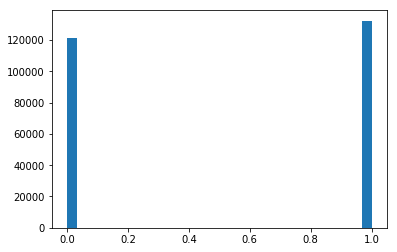

In [38]:
plt.hist(predicted_class, bins='auto')

In [46]:
vc.voting = 'soft'
global_accuracy_soft = accuracy_score(y_val, predicted_class)
global_f1_soft = f1_score(y_val, predicted_class)
#after voting, it looks no change
print('After voting ensemble:')
print('Accuracy score clfs: %f' % global_accuracy_soft)
print('F1 score clfs: %f' % global_f1_soft)

After voting ensemble:
Accuracy score clfs: 0.578013
F1 score clfs: 0.587755


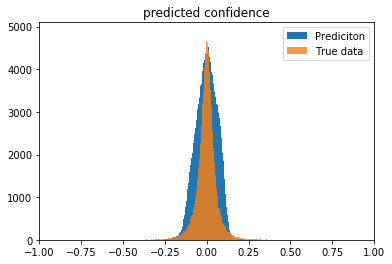

In [40]:
# Also no difference
plt.hist(predicted_return, bins='auto', label='Prediciton')
plt.hist(r_val, bins='auto',alpha=0.8, label='True data')
plt.title("predicted confidence")
plt.legend(loc='best')
plt.xlim(-1,1)
plt.show()

In [45]:
# It goes down a little
r_val = r_val.clip(-1,1)
x_t_i = predicted_return * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print('After voting ensemble, validation score', score_valid)

After voting ensemble, validation score 0.7463947564055972
